In [ ]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import re


Data shape: (1144, 5)
Missing values: id             0
title          0
link           0
content       24
gold_label     0
dtype: int64


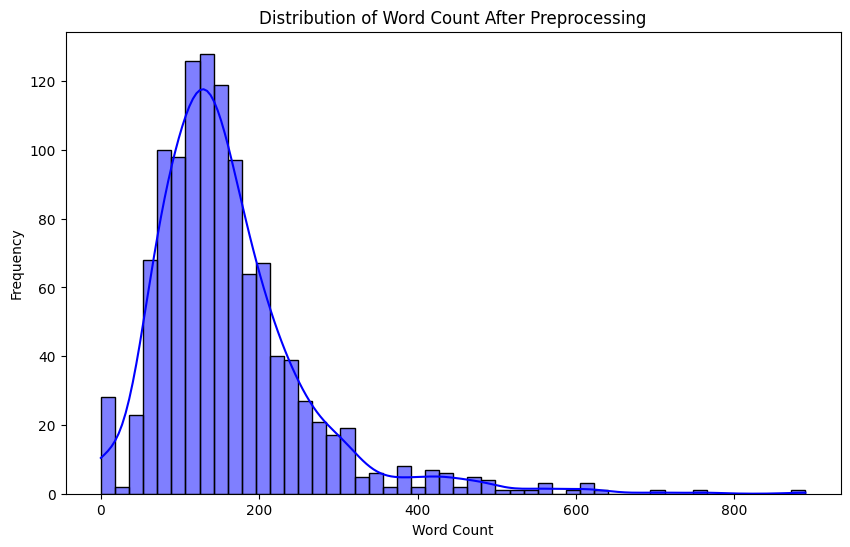


Random Samples After Preprocessing:
Sample 1: صدر پاکستان ٹیکس بار انور کاشف ممتاز مطالبہ ایف بی آر نل فائلرز ڈیسک آڈٹ کرے۔ انہوں کہا آج انکم ٹیکس گوشوارے جمع کرانے آخری تاریخ ہے، ملک فیصد گوشوارے جمع ہو چکے ہیں۔ انور کاشف کہا تشویش بات رواں سال آدھے گوشوارے نل فائل ہوئے۔ ایف بی آر انکم ٹیکس قواعد اہم ترامیم کر دیں۔ ایف بی آر مطابق آئندہ ایکٹو ٹیکس پیئرز لسٹ کو روزانہ بنیاد اپ ڈیٹ جائے گا۔ ان کہنا نل گوشوارے سسٹم کو دھوکا دینے، ایکٹیو فائلر رہنے اثاثے چھپانے لیے جمع کرائے جاتے ہیں۔ صدر پاکستان ٹیکس بار انور کاشف ممتاز کہا ایف بی آر ذمے داری ان گوشواروں ڈیسک آڈٹ کرے۔ واضح رہے فیڈرل بورڈ آف ریونیو چیئرمین راشد محمود لنگڑیال کو اکتوبر ء تک انکم ٹیکس گوشواروں ڈیٹا پیش کر دیا گیا ہے۔ ڈیٹا مطابق ء پاکستان بھر لاکھ ہزار ٹیکس گوشوارے جمع ہوئے ہیں۔ اکتوبر ء تک جمع کرائے گئے ٹیکس گوشواروں ساتھ ارب کروڑ لاکھ روپے ٹیکس جمع کر لیا گیا ہے۔
Sample 2: پاکستان ٹیم مڈل آرڈر بیٹر صاحبزادہ فرحان کہا محمد رضوان کپتانی کھیلنا مشکل ہوگا۔ کراچی میڈیا گفتگو صاحبزادہ فرحان کہا آسٹریلیا ٹور کرچکے ہیں و

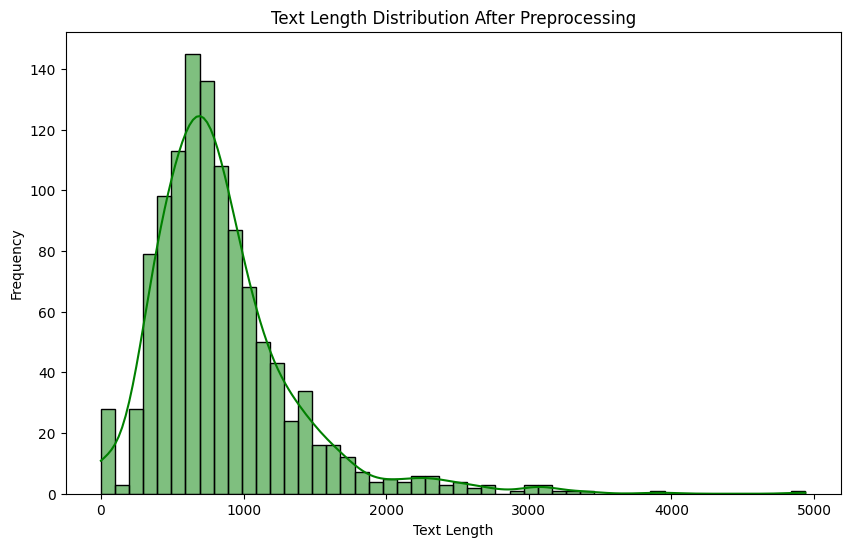

In [8]:
data = pd.read_csv('combined_articles.csv')

labels = data['gold_label'] #true labels
content = data['content'] #article content

# Define the preprocessing function
def preprocess_urdu_text(text):
    """
    Preprocess Urdu text by:
    1. Converting to lowercase
    2. Removing punctuation and special characters
    3. Removing extra whitespaces
    4. Removing stop words
    """
    # Stop words list 
    stop_words = {
        'کا', 'کی', 'کے', 'نے', 'میں', 'سے', 'پر', 'اور', 'کہ', 
        'جو', 'کہ', 'تو', 'ہے', 'تھا', 'ہوا', 'ہی', 'کیا', 'اس', 
        'یہ', 'نہیں', 'بھی', 'مگر', 'لیکن', 'وہ', 'ہم', 'تم', 'یہاں', 
        'وہاں', 'سب', 'کچھ', 'نیا', 'پہلے', 'جب', 'تاکہ', 'وہی', 
        'کیوں', 'کس', 'ایک', 'دو', 'تیس', 'چند', 'بہت', 'کم', 'زیادہ', 
        'کے', 'میں', 'پر', 'نے', 'دیکھ', 'کا', 'کیا', 'آپ', 'یہ', 'تو', 
        'یہ', 'سے', 'ہے', 'کا', 'سب', 'کیا', 'آئی', 'نہ', 'ہے', 'کی'
    }
    
    # Remove punctuation and special characters
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize
    tokens = text.split()
    
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]
    
    return ' '.join(filtered_tokens)

content = content.fillna('').astype(str)
content = content.apply(preprocess_urdu_text)

# Check for missing values
print("Data shape:", data.shape)
print("Missing values:", data.isnull().sum())

# Check number of words in each text after preprocessing
content_word_count = content.apply(lambda x: len(x.split()))

# Visualize the distribution of word count
plt.figure(figsize=(10, 6))
sns.histplot(content_word_count, kde=True, color='blue', bins=50)
plt.title('Distribution of Word Count After Preprocessing')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

#a few random samples of the cleaned content
random_samples = content.sample(5).tolist()

print("\nRandom Samples After Preprocessing:")
for i, sample in enumerate(random_samples):
    print(f"Sample {i + 1}: {sample}")

#text length distribution after preprocessing
text_length = content.apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(text_length, kde=True, color='green', bins=50)
plt.title('Text Length Distribution After Preprocessing')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
vectorizer = CountVectorizer(max_features=5000) #bag of words object 
x = vectorizer.fit_transform(content).toarray()
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# 70/30 train/val split
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.30, random_state=42)

# further split the 30% of val set into 1/3 test and 2/3rd val
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=1/3, random_state=42)

#tensor conversion
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_data = TensorDataset(x_train_tensor, y_train_tensor)
val_data = TensorDataset(x_val_tensor, y_val_tensor)
test_data = TensorDataset(x_test_tensor, y_test_tensor)

#make batches of data so as to make the processing efficient
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

#using dropout so as to prevent overfitting as it probablistically sets the value of activation to 0  
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # First layer : 128 neurons
        self.relu = nn.ReLU() 
        self.dropout1 = nn.Dropout(p=0.5)  # Dropout after first layer : 50% probability 
        self.fc2 = nn.Linear(128, 32)  # Second layer : 32 neurons
        self.dropout2 = nn.Dropout(p=0.5)  # Dropout after second layer same as first
        self.fc3 = nn.Linear(32, output_dim)  # Output layer : neurons = number of categories
        self.softmax = nn.Softmax(dim=1)  

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x) 
        x = self.relu(self.fc2(x))
        x = self.dropout2(x) 
        x = self.fc3(x)
        return self.softmax(x)


input_dimensions = x_train.shape[1]
output_dimensions = len(np.unique(labels))

NN = NeuralNetwork(input_dimensions, output_dimensions)

#L2 Regularization (Weight Decay) added to optimizer as it penalises large weights
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(NN.parameters(), lr=0.0015, weight_decay=0.0001)


def train(model, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_preds / total_preds * 100
    print(f"Epoch [{epoch+1}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")


def evaluate(model, val_loader):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.numpy())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Validation Accuracy: {accuracy:.4f}')


#use for testing
def evaluate_test(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.numpy())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Test Accuracy: {accuracy:.4f}')


#running 20 training and validation epochs
epochs = 20
for epoch in range(epochs):
    train(NN, train_loader, loss_function, optimizer, epoch)
    evaluate(NN, val_loader)

#evaluate on test set after training is complete
evaluate_test(NN, test_loader)





Epoch [1], Loss: 1.5418, Accuracy: 39.50%
Validation Accuracy: 0.7555
Epoch [2], Loss: 1.2451, Accuracy: 79.88%
Validation Accuracy: 0.9301
Epoch [3], Loss: 1.0525, Accuracy: 91.00%
Validation Accuracy: 0.9345
Epoch [4], Loss: 0.9947, Accuracy: 94.75%
Validation Accuracy: 0.9563
Epoch [5], Loss: 0.9674, Accuracy: 95.75%
Validation Accuracy: 0.9520
Epoch [6], Loss: 0.9544, Accuracy: 97.38%
Validation Accuracy: 0.9389
Epoch [7], Loss: 0.9495, Accuracy: 97.88%
Validation Accuracy: 0.9476
Epoch [8], Loss: 0.9413, Accuracy: 98.12%
Validation Accuracy: 0.9389
Epoch [9], Loss: 0.9406, Accuracy: 98.00%
Validation Accuracy: 0.9607
Epoch [10], Loss: 0.9417, Accuracy: 97.50%
Validation Accuracy: 0.9607
Epoch [11], Loss: 0.9314, Accuracy: 98.88%
Validation Accuracy: 0.9607
Epoch [12], Loss: 0.9342, Accuracy: 98.12%
Validation Accuracy: 0.9651
Epoch [13], Loss: 0.9274, Accuracy: 98.88%
Validation Accuracy: 0.9607
Epoch [14], Loss: 0.9294, Accuracy: 98.12%
Validation Accuracy: 0.9563
Epoch [15], Los